In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import shutil
import cv2 as cv

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, save_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

In [2]:
data = r'/kaggle/input/cauli12/Original Dataset/'
type_disea = os.listdir(data)
print(type_disea)
for i in type_disea:
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/test', i), exist_ok=True)
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/train', i), exist_ok=True)

def split_data_files(X, Y):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
  for i in range(len(X_train)): shutil.copy(os.path.join(os.path.join(data, y_train[i]),X_train[i]), os.path.join('/kaggle/working/dataset_split/train', y_train[i]))
  for i in range(len(X_test)) : shutil.copy(os.path.join(os.path.join(data, y_test[i]),X_test[i]), os.path.join('/kaggle/working/dataset_split/test', y_test[i]))
  
for folder in type_disea:
  X,Y = [],[]
  curr_path = os.path.join(data, folder)
  for filename in os.listdir(curr_path):
    X.append(filename)
    Y.append(folder)
  split_data_files(X, Y)

['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']


In [3]:
data = '/kaggle/working/dataset_split'

In [4]:
def create_df(TYPE):
  filepaths, labels = [],[]
  data_path = os.path.join(data, TYPE)
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
  return df

train_df = create_df('train').sample(frac=1, random_state=42)
test_df = create_df('test').sample(frac=1, random_state=42)

In [5]:
batch_size=20
img_size = (224, 224)
test  = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False)

Found 133 validated image filenames belonging to 4 classes.


In [6]:
img_shape = (img_size[0], img_size[1], 3)
def get_model():
  base_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
  base_model.trainable = True
  x = base_model.output
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(4, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=outputs)
  lr=.001
  model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [7]:
def make_balance_train(df, num_fol):
  generate_more_data(df, num_fol)
  aug_df = create_df_more(num_fol)
  new_df = pd.concat([df, aug_df], ignore_index=True)
  return new_df
# make_balance_train(train_df.loc[train_idx])

In [8]:
def min_len_arr(df):
  minlenarr = []
  for i in type_disea:
    minlenarr.append(len(df.loc[df['labels']==i]))
  return minlenarr
# print(min_len_arr(train_df.loc[train_idx]))

def generate_more_data(df, num_fol):
    gene = ImageDataGenerator(brightness_range=[0.2,2.0],vertical_flip=True,shear_range=20)
    len_disea = min_len_arr(df)
    print(len_disea)
    max_disea = max(len_disea)
#     print(max_disea)
    for i in type_disea:
        num_of_disea = len_disea[type_disea.index(i)]
        cur_path = os.path.join(f'/kaggle/working/more_img{num_fol}',i)
        create_img = gene.flow_from_dataframe(df.loc[df['labels']==i], x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=1, save_to_dir=cur_path, save_format='jpg')
        if i == type_disea[len_disea.index(max_disea)]: pass
        else:
            for j in range(0, max_disea-num_of_disea):
              hh = next(create_img)       
# generate_more_data(train_df.loc[train_idx],1)

def create_df_more(num_fol):
  filepaths, labels = [],[]
  data_path = f'/kaggle/working/more_img{num_fol}'
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
#   print(df)
  return df

In [9]:
def create_fol(n):
  os.makedirs(f'/kaggle/working/more_img{n}', exist_ok=True)
  for i in type_disea:
    os.makedirs(os.path.join(f'/kaggle/working/more_img{n}', i), exist_ok=True)

[108, 67, 111, 132]
Found 108 validated image filenames belonging to 1 classes.
Found 67 validated image filenames belonging to 1 classes.
Found 111 validated image filenames belonging to 1 classes.
Found 132 validated image filenames belonging to 1 classes.
Found 528 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726935509.973634      99 service.cc:145] XLA service 0x7da460006040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726935509.973691      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726935589.103068      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 253s 8s/step - accuracy: 0.5148 - loss: 1.3350 - val_accuracy: 0.5714 - val_loss: 1.8956
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9307 - loss: 0.2402 - val_accuracy: 0.6190 - val_loss: 2.2749
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9797 - loss: 0.0643 - val_accuracy: 0.5619 - val_loss: 2.1863
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9654 - loss: 0.0879 - val_accuracy: 0.7524 - val_loss: 1.0679
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9671 - loss: 0.0833 - val_accuracy: 0.8857 - val_loss: 0.4400
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9760 - loss: 0.0755 - val_accuracy: 0.8952 - val_loss: 0.3355
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9832 - loss: 0.0565 - val_accuracy: 0.9524 - val_loss: 0.1418
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9922 - loss: 0.0184 - val_accuracy: 0.9619 - val_loss: 0.0963
Ep

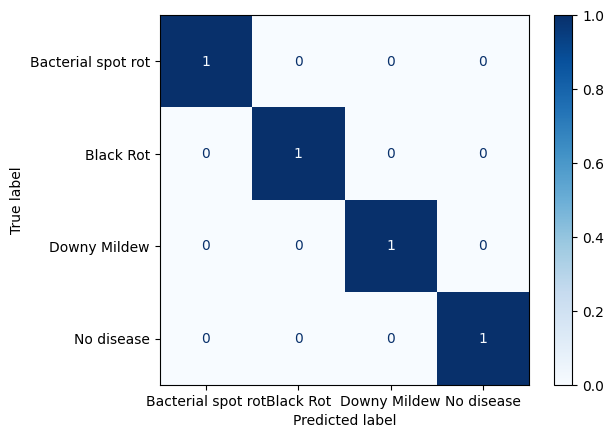

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      1.00      1.00        20
      Downy Mildew       1.00      1.00      1.00        36
        No disease       1.00      1.00      1.00        42

          accuracy                           1.00       133
         macro avg       1.00      1.00      1.00       133
      weighted avg       1.00      1.00      1.00       133

[109, 64, 109, 136]
Found 109 validated image filenames belonging to 1 classes.
Found 64 validated image filenames belonging to 1 classes.
Found 109 validated image filenames belonging to 1 classes.
Found 136 validated image filenames belonging to 1 classes.
Found 544 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.5338 - loss: 1.1862 - val_accuracy: 0.3714 - val_loss: 3.3726
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8981 - loss: 0.2680 - val_accuracy: 0.5619 - val_loss: 1.5776
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9625 - loss: 0.1187 - val_accuracy: 0.8571 - val_loss: 0.6310
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9886 - loss: 0.0397 - val_accuracy: 0.8857 - val_loss: 0.3692
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9878 - loss: 0.0295 - val_accuracy: 0.9429 - val_loss: 0.1934
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9930 - loss: 0.0242 - val_accuracy: 0.9619 - val_loss: 0.1005
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9953 - loss: 0.0283 - val_accuracy: 0.9810 - val_loss: 0.0735
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9970 - loss: 0.0126 - val_accuracy: 0.9810 - val_loss: 0.0476
Ep

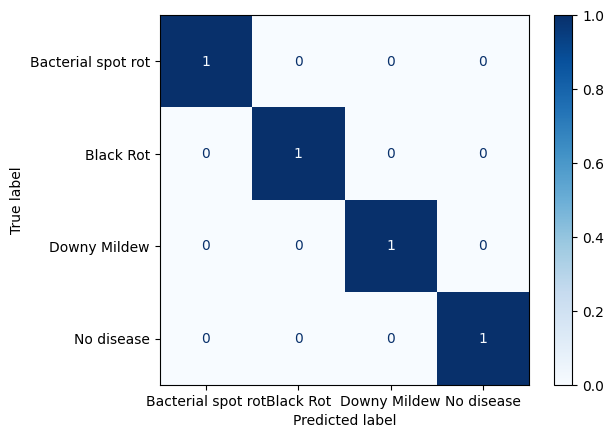

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      1.00      1.00        20
      Downy Mildew       1.00      1.00      1.00        36
        No disease       1.00      1.00      1.00        42

          accuracy                           1.00       133
         macro avg       1.00      1.00      1.00       133
      weighted avg       1.00      1.00      1.00       133

[119, 64, 110, 125]
Found 119 validated image filenames belonging to 1 classes.
Found 64 validated image filenames belonging to 1 classes.
Found 110 validated image filenames belonging to 1 classes.
Found 125 validated image filenames belonging to 1 classes.
Found 500 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 235s 8s/step - accuracy: 0.4792 - loss: 1.3020 - val_accuracy: 0.5619 - val_loss: 1.2138
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8704 - loss: 0.3132 - val_accuracy: 0.8571 - val_loss: 0.4767
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9603 - loss: 0.1112 - val_accuracy: 0.9238 - val_loss: 0.2037
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9747 - loss: 0.0611 - val_accuracy: 0.9619 - val_loss: 0.1713
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9894 - loss: 0.0384 - val_accuracy: 0.9810 - val_loss: 0.0490
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9880 - loss: 0.0441 - val_accuracy: 1.0000 - val_loss: 0.0259
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9976 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.0178
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9801 - loss: 0.0821 - val_accuracy: 0.9714 - val_loss: 0.0413
Ep

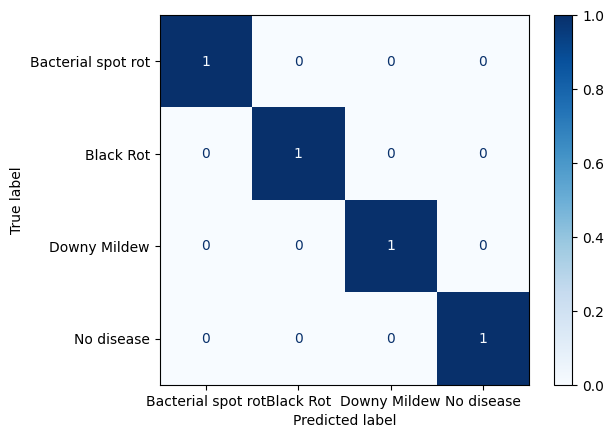

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      1.00      1.00        20
      Downy Mildew       1.00      1.00      1.00        36
        No disease       1.00      1.00      1.00        42

          accuracy                           1.00       133
         macro avg       1.00      1.00      1.00       133
      weighted avg       1.00      1.00      1.00       133

[119, 66, 108, 126]
Found 119 validated image filenames belonging to 1 classes.
Found 66 validated image filenames belonging to 1 classes.
Found 108 validated image filenames belonging to 1 classes.
Found 126 validated image filenames belonging to 1 classes.
Found 504 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 240s 8s/step - accuracy: 0.5251 - loss: 1.2576 - val_accuracy: 0.6058 - val_loss: 1.5301
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8781 - loss: 0.3252 - val_accuracy: 0.5865 - val_loss: 1.1354
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9644 - loss: 0.1165 - val_accuracy: 0.5865 - val_loss: 1.1385
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9689 - loss: 0.0791 - val_accuracy: 0.8269 - val_loss: 0.5432
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9899 - loss: 0.0377 - val_accuracy: 0.9135 - val_loss: 0.3845
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9864 - loss: 0.0519 - val_accuracy: 0.9327 - val_loss: 0.3065
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9766 - loss: 0.0553 - val_accuracy: 0.9327 - val_loss: 0.2499
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9902 - loss: 0.0391 - val_accuracy: 0.9423 - val_loss: 0.2616
Ep

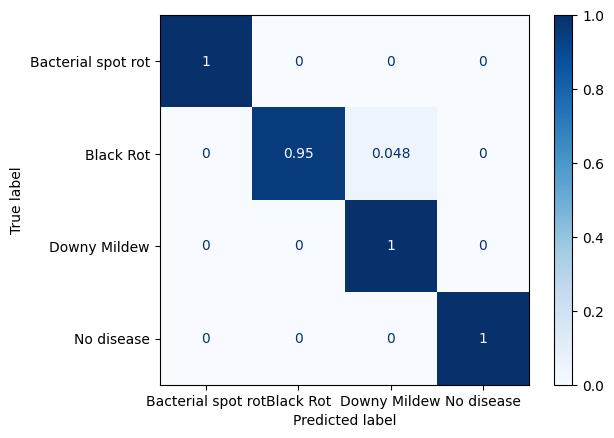

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133

[109, 59, 114, 137]
Found 109 validated image filenames belonging to 1 classes.
Found 59 validated image filenames belonging to 1 classes.
Found 114 validated image filenames belonging to 1 classes.
Found 137 validated image filenames belonging to 1 classes.
Found 548 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.4884 - loss: 1.3332

I0000 00:00:1726938947.130856      99 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_418', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 356 bytes spill stores, 356 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_416', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_414', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 36 bytes spill stores, 36 bytes spill loads



18/18 ━━━━━━━━━━━━━━━━━━━━ 246s 8s/step - accuracy: 0.5067 - loss: 1.2854 - val_accuracy: 0.3269 - val_loss: 2.8249
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9171 - loss: 0.2368 - val_accuracy: 0.5962 - val_loss: 1.4113
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9539 - loss: 0.1339 - val_accuracy: 0.8173 - val_loss: 0.7088
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9774 - loss: 0.0730 - val_accuracy: 0.9231 - val_loss: 0.2529
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9650 - loss: 0.0867 - val_accuracy: 0.9615 - val_loss: 0.0821
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9799 - loss: 0.0631 - val_accuracy: 0.9808 - val_loss: 0.0331
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9969 - loss: 0.0192 - val_accuracy: 0.9904 - val_loss: 0.0178
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9901 - loss: 0.0263 - val_accuracy: 1.0000 - val_loss: 0.0084
Ep

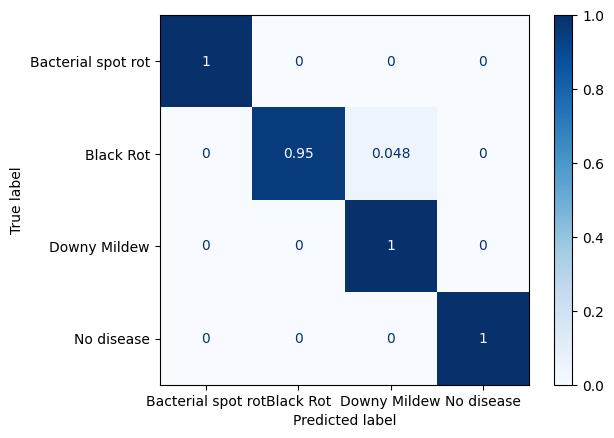

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133



In [10]:
k = StratifiedKFold(n_splits=5,shuffle=True)
k.get_n_splits(train_df['filepaths'], train_df['labels'])

epochs = 15
gen = ImageDataGenerator(horizontal_flip=True, rotation_range=30, width_shift_range=.2, height_shift_range=.2, zoom_range=.2)
for i, (train_idx, valid_idx) in enumerate(k.split(train_df['filepaths'], train_df['labels'])):
  create_fol(i) 
  a = make_balance_train(train_df.loc[train_idx], i)
  b = train_df.loc[valid_idx]
  train = gen.flow_from_dataframe(a, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)
  valid = ImageDataGenerator().flow_from_dataframe(b, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True)  
  
  model = get_model()
  history = model.fit(x=train, epochs=epochs, validation_data=valid, validation_steps=None, shuffle=False, initial_epoch=0)
  history_dict = history.history
  class_indices = list(train.class_indices.values())
  class_names = list(train.class_indices.keys())
  preds = model.predict(test)
  label = test.labels
  list_pred = []
  errors = 0
  for i, p in enumerate(preds):
    index = np.argmax(p)
    list_pred.append(index)
    if class_indices[index] != label[i]:
      errors+=1
  acc = (1.0 - errors/len(preds)) * 100
  print('Errors = ', errors, "Acc = ", acc)
  cm = confusion_matrix(list_pred, label, normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()
  report = classification_report(list_pred, label,target_names=class_names)
  print(report)